# Reinforcement Learning

# 4. Online control

This notebook presents the **online control** of an agent by SARSA and Q-learning.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from utils.model import TicTacToe, Nim, ConnectFour
from utils.agent import Agent, OnlineControl
from utils.dynamic import ValueIteration

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML

def display_answer(title, answer):
    if isinstance(answer, list):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1><ul>"""
        for a in answer:
            string_display += f"<li>{a}</li>"
        string_display += "</ul></div>"
    elif isinstance(answer, str):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1>{answer} </div>"""
    else:
        raise ValueError("Answer should be a string or a list of strings.")
    display(HTML(string_display))

## To do

* Complete the class ``SARSA`` and test it on Tic-Tac-Toe.
* Complete the class ``QLearning`` and test it on Tic-Tac-Toe.
* Compare these algorithms on Tic-Tac-Toe (play first) and Nim (play second), using a random adversary, then a perfect adversary. Comment your results.
* Test these algorithms on Connect 4 against a random adversary. Comment your results.

## SARSA

In [3]:
class SARSA(OnlineControl):
    """Online control by SARSA."""
        
    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        if not self.model.is_terminal(state):
            action = self.randomize_best_action(state, epsilon=epsilon)
            for t in range(horizon):
                code = self.model.encode(state)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)
                # to be modified (get sample gain)
                # begin
                gain = reward
                # end
                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                if stop:
                    break
                # to be modified (update state and action)
                # begin
                state = self.model.state
                action = self.randomize_best_action(state, epsilon=epsilon)
                # end

## Q-learning

In [4]:
class QLearning(OnlineControl):
    """Online control by Q-learning."""
        
    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        if not self.model.is_terminal(state):
            for t in range(horizon):
                code = self.model.encode(state)
                action = self.randomize_best_action(state, epsilon=epsilon)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)
                gain = reward
                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                if stop:
                    break
                state = self.model.state

## To do

Simulating TicTacToe with SARSA control and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating TicTacToe with SARSA control and perfect adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating TicTacToe with QLearning control and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating TicTacToe with QLearning control and perfect adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Nim with SARSA control and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Nim with SARSA control and perfect adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Nim with QLearning control and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Nim with QLearning control and perfect adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

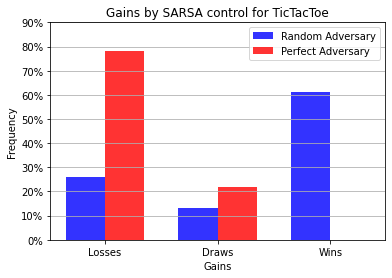

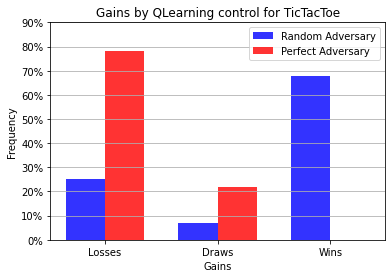

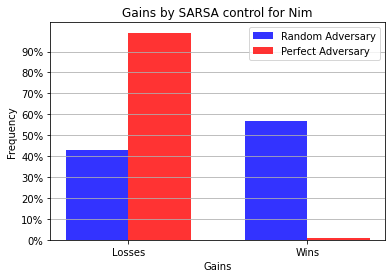

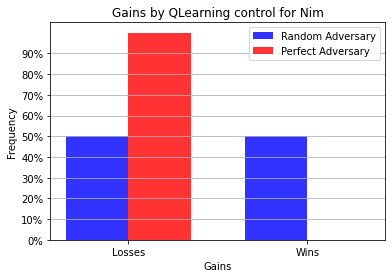

In [18]:
gains = {}
issues = {'TicTacToe': np.array([-1., 0., 1.]), 'Nim': np.array([-1., 1.])}
ticks = {'TicTacToe': (np.array([-1., 0., 1.]), ['Losses', 'Draws', 'Wins']), 'Nim': (np.array([0., 1.]), ['Losses', 'Wins'])}
play_first = {'TicTacToe': True, 'Nim': False}
n_games = 1000
n_run = 100
for Game in [TicTacToe, Nim]:
    gains_game = {}
    adversary_policies = {'random': 'random', 'perfect': ValueIteration(Game(play_first=play_first[Game.__name__])).get_perfect_players()[1]}
    for Control in [SARSA, QLearning]:
        gains_algo = {}
        for adversary_policy in ['random', 'perfect']:
            game = Game(adversary_policy=adversary_policies[adversary_policy], play_first=play_first[Game.__name__])
            agent = Agent(game)
            algo = Control(game)
            for i in tqdm(range(n_games), desc=f'Simulating {game.__class__.__name__} with {algo.__class__.__name__} control and {adversary_policy} adversary'):
                algo.update_values(epsilon=0.1, horizon=500)

            policy = algo.get_policy()
            agent = Agent(game, policy)
            gain = agent.get_gains(n_runs=n_run)
            gains_algo[adversary_policy] = np.array([np.sum(gain==k) for k in issues[game.__class__.__name__]])
        gains_game[algo.__class__.__name__] = gains_algo
    gains[game.__class__.__name__] = gains_game

for game, gains_game in gains.items():
    list_answers = []
    for algo, gains_algo in gains_game.items():
        for adversary_policy, gains in gains_algo.items():
            list_answers.append(f'<b>{algo} control, {adversary_policy} adversary</b>: mean of gains is about {np.multiply(issues[game], gains).sum()/n_run:.2f}')
        # Show bar plot against different adversaries
        fig, ax = plt.subplots()
        bar_width = 0.35
        index = ticks[game][0]
        opacity = 0.8
        rects1 = plt.bar(index - bar_width/2, gains_algo['random'], bar_width, alpha=opacity, color='b', label='Random Adversary')
        rects2 = plt.bar(index + bar_width/2, gains_algo['perfect'], bar_width, alpha=opacity, color='r', label='Perfect Adversary')
        plt.xlabel('Gains')
        plt.ylabel('Frequency')
        plt.yticks(np.arange(0, 100, 10), [f'{i}%' for i in np.arange(0, 100, 10)])
        plt.grid(axis='y')
        plt.xticks(index, ticks[game][1])
        plt.title(f'Gains by {algo} control for {game}')
        plt.legend()
        plt.show()
    display_answer(f'{game} results', list_answers)
